# CSE 5524 HW9 Utkarsh Pratap Singh Jadon

## Question 1

### Import necessary libraries

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np
import math
from PIL import Image
import glob
import os
import skimage
import scipy.ndimage
from os import listdir
from os.path import join, isfile
from skimage import morphology
from skimage import measure,color
from skimage import io, data 
from numpy.linalg import eig
from scipy import ndimage, misc
from scipy.ndimage import median_filter
import matplotlib.patches as patches

### Load 2D and 3D points data

In [56]:
twoDimensionPoints = np.loadtxt('2Dpoints.txt')
threeDimensionPoints = np.loadtxt('3Dpoints.txt')

print(twoDimensionPoints.shape)
print(threeDimensionPoints.shape)

(100, 2)
(100, 3)


### Create arrays x,y for 2D points and X,Y,Z for 3D points

In [57]:
x = twoDimensionPoints[:,0]
y = twoDimensionPoints[:,1]

X = threeDimensionPoints[:,0]
Y = threeDimensionPoints[:,1]
Z = threeDimensionPoints[:,2]

### Compute A matrix

In [61]:
A = []

for i in range(100):
    Aeven = np.zeros(12)
    Aodd = np.zeros(12)
    
    Aeven[0:4] = [X[i], Y[i], Z[i], 1]
    Aeven[4:8] = 0
    Aeven[8:12] = [-(X[i]*x[i]), -Y[i]*x[i], -Z[i]*x[i], -x[i]]
    
    Aodd[0:4] = 0
    Aodd[4:8] = [X[i], Y[i], Z[i], 1]
    Aodd[8:12] = [-(X[i]*y[i]), -Y[i]*y[i], -Z[i]*y[i], -y[i]]
    
    A.append(Aeven)
    A.append(Aodd)

A = np.array(A)
print(A[0])

[ 8.89560004e+03 -3.42725524e+02  7.29791079e+03  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.04749802e+06  1.55940113e+05 -3.32054941e+06 -4.55000000e+02]


### Compute camera matrix P using eigen-decomposition

In [62]:
B = np.dot((np.transpose(A)),A)
value,vector = eig(B)

rasterizedVectorP = vector[:,np.argmin(value)]
normValue = np.linalg.norm(rasterizedVectorP)
print("L2 norm of rasterized matrix P is: {}".format(normValue))

cameraMatrixP = rasterizedVectorP.reshape(3,4)
print("Camera Matrix P is: ")
print(cameraMatrixP)

L2 norm of rasterized matrix P is: 1.0
Camera Matrix P is: 
[[ 2.12330972e-03  2.03511592e-03  1.66862974e-03 -9.12321856e-01]
 [-6.18900232e-04  1.38205180e-04  2.75867489e-03 -4.09449553e-01]
 [ 4.24759285e-06 -2.12813147e-06  3.68281248e-06 -6.69704629e-04]]


## Question 2

### Project 3D homogenous points to 2D

In [63]:
threeDimensionArray = np.zeros((4,100))
threeDimensionArray[0][:] = X
threeDimensionArray[1][:] = Y
threeDimensionArray[2][:] = Z
threeDimensionArray[3][:] = 1

threeDimensionProjected = np.zeros((3,100))
threeDimensionProjected = np.dot((cameraMatrixP), (threeDimensionArray))

threeDimensionProjectedInhomo = np.zeros((2,100))

threeDimensionProjectedInhomo = threeDimensionProjected / threeDimensionProjected[2][:]

#print(threeDimensionProjectedInhomo[:,0])

### Find sum-of-squared error between 3D-to-2D projected points and given 2D points

In [64]:
twoDimensionArray = np.zeros((3,100))
twoDimensionArray[0][:] = x
twoDimensionArray[1][:] = y
twoDimensionArray[2][:] = 1

#print(twoDimensionArray.shape)
#print(threeDimensionProjectedInhomo.shape)

a,b = twoDimensionArray.shape
SSE = 0
for i in range(a):
    for j in range(b):
        
        SSE += (twoDimensionArray[i][j] - threeDimensionProjectedInhomo[i][j]) ** 2
print("Sum-of-squared error is: {}".format(SSE))

Sum-of-squared error is: 18.74676180563793


### Discussion

I stored the given 3D and 2D coordinates in respective arrays and created an A matrix derived from the equations. Then using eigen decomposition on A(transpose)*A, the eigen vector corresponding to smallest eigen value gives the rasterized camera matrix 'p'. I unrasterized 'p' to 3x4 matrix to get the required camera matrix P. Finally I calculated the sum-of-squared error between 3D-2D projected points and given 2D points.

## Question 3

### Read and load data for two different images into one array

In [65]:
textFile = np.genfromtxt('homography.txt',dtype='str')
data = []
for i in range(textFile.shape[0]):
    a = textFile[i].split(',')
    a = np.array(a)
    data.append(a.astype(np.int))
textData = np.array(data)
#print(textData)

/var/folders/_z/7q8tzcpd3s7cr5lz406qzczw0000gn/T/ipykernel_952/484546293.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(a.astype(np.int))


### Store data in homogenous arrays image1Array and image2Array

In [66]:
image1Array = np.zeros((3,15))
image1Array[0] = textData[:,0]
image1Array[1] = textData[:,1]
image1Array[2] = 1

image2Array = np.zeros((3,15))
image2Array[0] = textData[:,2]
image2Array[1] = textData[:,3]
image2Array[2] = 1

### Create transformer matrix T1 for image1

In [67]:
#Image 1 coordinates stored in 3x15 image1Array
T1 = np.zeros((3,3))

image1xMean = np.mean(image1Array[0])
image1yMean = np.mean(image1Array[1])
# print(image1xMean)
# print(image1yMean)

denominator = 0
total = 0

a,b = image1Array.shape
for i in range(b):
    total += np.sqrt((image1Array[0][i] - image1xMean)**2 + (image1Array[1][i] - image1yMean)**2)
denominator = total / 15
s1 = (np.sqrt(2) / denominator)        
# print(s1)

T1[0][:] = [s1, 0, -s1*image1xMean]
T1[1][:] = [0, s1, -s1*image1yMean]
T1[2][:] = [0, 0, 1]

print(T1)

[[ 0.00621974  0.         -2.00316977]
 [ 0.          0.00621974 -1.24892307]
 [ 0.          0.          1.        ]]


### Create transformer matrix T2 for image2

In [68]:
#Image 2 coordinates stored in 3x15 image2Array
T2 = np.zeros((3,3))

image2xMean = np.mean(image2Array[0])
image2yMean = np.mean(image2Array[1])
# print(image2xMean)
# print(image2yMean)

denominator = 0
total = 0

a,b = image2Array.shape
for i in range(b):
    total += np.sqrt((image2Array[0][i] - image2xMean)**2 + (image2Array[1][i] - image2yMean)**2)
denominator = total / 15
s2 = (np.sqrt(2) / denominator)        
# print(s2)

T2[0][:] = [s2, 0, -s2*image2xMean]
T2[1][:] = [0, s2, -s2*image2yMean]
T2[2][:] = [0, 0, 1]

print(T2)

[[ 0.00964691  0.         -3.27094465]
 [ 0.          0.00964691 -2.16155033]
 [ 0.          0.          1.        ]]


### Find normalised 2D points for image1 and image2 using T1 and T2 respectively

In [69]:
# image1ArrayNormalised[3x15] = T1[3x3] * image1Array[3x15]

image1ArrayNormalised = np.zeros((3,15))
image1ArrayNormalised = np.dot(T1,image1Array)

# image2ArrayNormalised[3x15] = T2[3x3] * image2Array[3x15]

image2ArrayNormalised = np.zeros((3,15))
image2ArrayNormalised = np.dot(T2,image2Array)

### Compute A matrix

In [70]:
A = []

for i in range(15):
    Aeven = np.zeros(9)
    Aodd = np.zeros(9)
    
    Aeven[0:3] = [image1ArrayNormalised[0][i], image1ArrayNormalised[1][i], 1]
    Aeven[3:6] = [0, 0, 0]
    Aeven[6:9] = [-(image1ArrayNormalised[0][i]*image2ArrayNormalised[0][i]), -image1ArrayNormalised[1][i]*image2ArrayNormalised[0][i], -image2ArrayNormalised[0][i]]
    
    Aodd[0:3] = [0, 0, 0]
    Aodd[3:6] = [image1ArrayNormalised[0][i], image1ArrayNormalised[1][i], 1]
    Aodd[6:9] = [-(image1ArrayNormalised[0][i]*image2ArrayNormalised[1][i]), -image1ArrayNormalised[1][i]*image2ArrayNormalised[1][i], -image2ArrayNormalised[1][i]]
    
    A.append(Aeven)
    A.append(Aodd)

A = np.array(A)
print(A.shape)


(30, 9)


### Compute normalised-Homography matrix H' using eigen-decomposition

In [78]:
B = np.dot((np.transpose(A)),A)
value,vector = eig(B)

rasterizedVectorH = vector[:,np.argmin(value)]
normValue = np.linalg.norm(rasterizedVectorH)
print("L2 norm of rasterized matrix H is: {}".format(normValue))

normalisedHomographyH = rasterizedVectorH.reshape(3,3)
print("Normalised Homography Matrix H' is: ")
print(normalisedHomographyH)

L2 norm of rasterized matrix H is: 1.0
Normalised Homography Matrix H' is: 
[[ 0.46200264  0.57504495  0.10529965]
 [-0.18627971  0.30385731 -0.00159494]
 [ 0.04249082  0.05379765  0.55951519]]


### Compute final Homography matrix H

In [79]:
finalHomographyH = np.zeros((3,3))
finalHomographyH = np.dot((np.dot(np.linalg.inv(T2), normalisedHomographyH)), T1)
print("Final Homography matrix H that maps original points from Image 1 to Image 2 is: ")
print(finalHomographyH)


Final Homography matrix H that maps original points from Image 1 to Image 2 is: 
[[ 3.87480204e-01  4.84207998e-01 -2.13950934e+01]
 [-6.08850486e-02  2.70882946e-01  9.04191215e+01]
 [ 2.64281729e-04  3.34607182e-04  4.07209735e-01]]


### Plot Image 2 points and projected points from Image 1

In [80]:
projectedPoints = np.zeros((3,15))
projectedPoints = np.dot((finalHomographyH), (image1Array))

projectedPointsInhomo = np.zeros((2,100))

projectedPointsInhomo = projectedPoints / projectedPoints[2][:]

#print(projectedPointsInhomo[:,0])

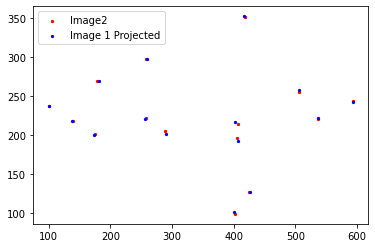

In [81]:
plt.scatter(image2Array[0],image2Array[1],color = 'red',s=5)
plt.scatter(projectedPointsInhomo[0],projectedPointsInhomo[1],color = 'blue',s=5)
plt.legend(['Image2', 'Image 1 Projected'],loc='upper left')

### Find sum-of-squared error between Image 2 points and projected points from Image 1

In [82]:
a,b = image2Array.shape
SSE = 0
for i in range(a):
    for j in range(b):
        SSE += (image2Array[i][j] - projectedPointsInhomo[i][j]) ** 2

print("Sum-of-squared error is: {}".format(SSE))

Sum-of-squared error is: 105.97387926939389


### Discussion

I stored the given Image 1 and Image 2 points in respective arrays and computed transformer matrices T1 and T2 to get normalised points from Image 1 and Image 2 respectively. Then I created an A matrix derived from the equations. Using eigen decomposition on A(transpose)*A, the eigen vector corresponding to smallest eigen value gives the normalised rasterized homography matrix 'h'. I unrasterized 'h' to 3x3 matrix to get the normalised homography matrix H'. Using T1(inv) and T2 transformed matrices, I calculated required un-normalised homography matrix H. After projecting and plotting points from Image 1 to Image 2, I finally calculated sum-of-squared errors between image 2 points and projected points from image 1.